# Compare data from Collection 3 to Collection 2 Fractional Cover
Using data from around LBG

In [3]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser, write_geotiff

# Import external functions from dea-notebooks
sys.path.append('../Scripts/')
import dea_plotting, dea_datahandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

In [12]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')
ds = dc.load(product="ga_ls_fc_3",
            output_crs='epsg:3577',
            resolution =(-30,30),
            group_by = 'solar_day',
            lat = (-35.25, -35.35),
            lon = (149.05, 149.17),
            time = ('2013', '2014'))
print(ds)

<xarray.Dataset>
Dimensions:      (time: 6, x: 410, y: 417)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-18T23:52:06.191456 ... 2013-06...
  * y            (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x            (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) uint8 20 26 24 34 36 33 30 24 ... 0 0 0 0 0 0 0 0
    pv           (time, y, x) uint8 40 37 38 35 41 39 41 ... 44 44 46 46 45 43
    npv          (time, y, x) uint8 38 35 37 30 22 27 28 ... 59 58 56 57 57 59
    ue           (time, y, x) uint8 27 24 19 18 19 15 18 16 ... 4 5 5 4 4 4 4 4
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


### Mask out nodata values by setting NaN = 255

In [17]:
ds = ds.where(ds!=255)

### Plot Fractional Cover and Unmixing Error Bands
Note that Unmixing Error is high over water

In [18]:
#just a scene we want to plot - this can be done other ways
scene = 0

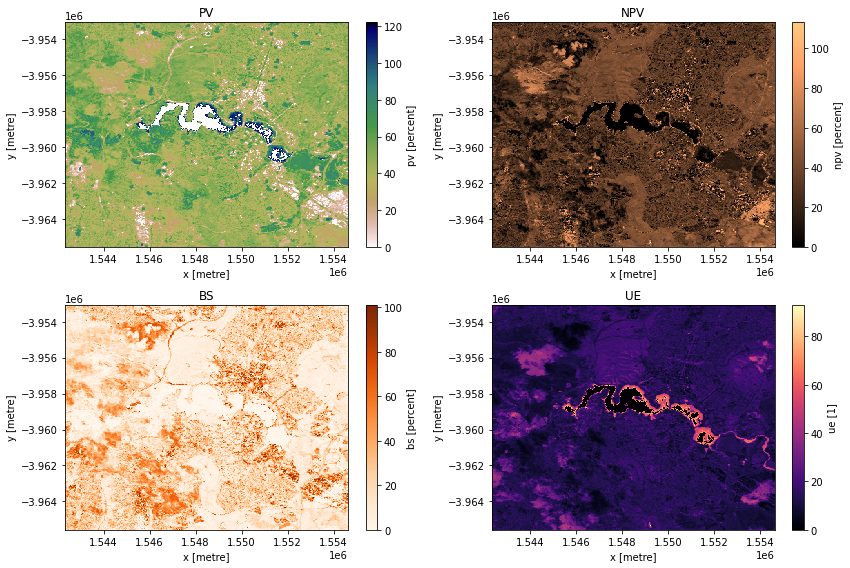

In [20]:
#set up our images on a grid using gridspec
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.pv.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
ds.bs.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
ds.npv.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
ds.ue.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### We could filter using the unmixing error, but using WOfS is more robust.

Text(0.5, 1.0, 'UE filtered')

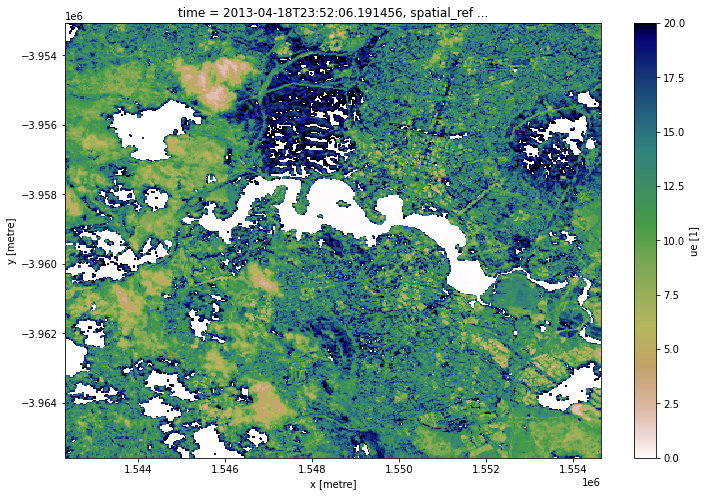

In [22]:
#this image shows that you can filter using unmixing error if you wish
plt.figure(figsize=(12,8))
ds.ue.where(ds.ue<=20.0).isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('UE filtered')

## Filter fractional cover scenes using WOfS feature layers (WOFLs) 
- Use the wofs dataset to create scene-by-scene masks to remove areas of water
- For more information on WOfS, see the [DEA WOfS and Water Classifier Notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Image_classification/DEA_WOfS_and_water_classifier.ipynb)
- There may be errors in the WOfS tiles until WOfS is finished 

### load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

In [23]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'ga_ls_wofs_3 ', like=ds)

ValueError: No products match search terms: {'time': Range(begin=datetime.datetime(2013, 4, 18, 23, 52, 6, 191456, tzinfo=<UTC>), end=datetime.datetime(2013, 6, 5, 23, 52, 20, 231320, tzinfo=tzutc())), 'lat': Range(begin=-35.36309666104742, end=-35.23679793167617), 'lon': Range(begin=149.03374542288958, end=149.18643839578797), 'product': 'ga_ls_wofs_3 '}

### Two ways of displaying what the values in the wofs data mean:
WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise

In [12]:
masking.describe_variable_flags(wofls, with_pandas=True)

,bits,values,description
cloud,6,"{'0': False, '1': True}",Cloudy
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},No water detected
high_slope,4,"{'0': False, '1': True}",High slope
nodata,0,{'1': True},No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",terrain shadow or low solar angle
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


In [13]:
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))

dry  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0': True}, 'description': 'No water detected'}
sea  {'bits': 2, 'values': {'0': False, '1': True}, 'description': 'Sea'}
wet  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'128': True}, 'description': 'Clear and Wet'}
cloud  {'bits': 6, 'values': {'0': False, '1': True}, 'description': 'Cloudy'}
nodata  {'bits': 0, 'values': {'1': True}, 'description': 'No data'}
high_slope  {'bits': 4, 'values': {'0': False, '1': True}, 'description': 'High slope'}
cloud_shadow  {'bits': 5, 'values': {'0': False, '1': True}, 'description': 'Cloud shadow'}
noncontiguous  {'bits': 1, 'values': {'0': False, '1': True}, 'description': 'At least one EO band is missing over over/undersaturated'}
terrain_or_low_angle  {'bits': 3, 'values': {'0': False, '1': True}, 'description': 'terrain shadow or low solar angle'}


### Here is what the WOFL mask looks like on one timestep:

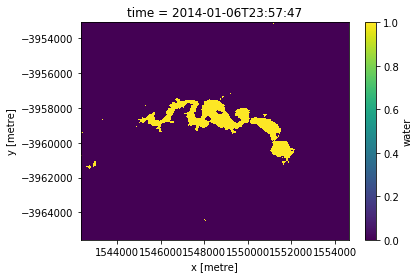

In [14]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=0).plot()
#drywofl = masking.make_mask(wofls, dry=True)
#drywofl.water.isel(time=0).plot()

In [15]:
#match WOFL times to our fractional cover times
unwofld = ds.where(ds.time == wetwofl.time)
#mask out water from fractional cover
unwofld = unwofld.where(wetwofl.water==False)

### Here is what Fractional Cover looks like with WOFL removed:

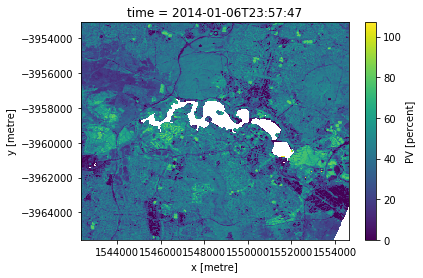

In [16]:
unwofld.PV.isel(time=0).plot()

### Edit save file path to choose where to save your output files

In [17]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save Fractional Cover scenes to NetCDF


In [18]:
try:
    DEADataHandling.write_your_netcdf(unwofld, 'FC25', savefilepath+'FC25'+'.nc', crs = ds.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

RuntimeError: Storage Unit already exists: /home/547/rjd547/FC25.nc
wrote to netCDF


## Save Fractional Cover scenes to GeoTIFF


In [19]:
ds = unwofld
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'FC25_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'FC25_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF


## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

2. TERN Auscover, 2012. *Fractional cover - Landsat, Joint Remote Sensing Research Program algorithm, Australia coverage.* Last modified by Peter Scarth on 2017/03/24 09:53. http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover